<a href="https://colab.research.google.com/github/raffeekk/KP-TOBD1/blob/main/%D0%BA%D0%BE%D0%BD%D1%82%D1%80%D0%BE%D0%BB%D1%8C%D0%BD%D0%B0%D1%8F%201%D0%93%D0%BE%D1%80%D0%B1%D1%83%D0%BD%D0%B5%D0%BD%D0%BA%D0%BE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Контрольная работа №1



In [1]:
# Ссылки на исходные данные
url_climate = "https://raw.githubusercontent.com/raffeekk/KP-TOBD1/refs/heads/main/jena_climate_2009_2016.csv"
url_diabetes = "https://raw.githubusercontent.com/raffeekk/KP-TOBD1/refs/heads/main/diabetes_dataset%20(1).csv"
url_image = "https://raw.githubusercontent.com/raffeekk/KP-TOBD1/refs/heads/main/image1%20(1).jpeg"

## Задание 1 — Преобразование Фурье для климатических данных

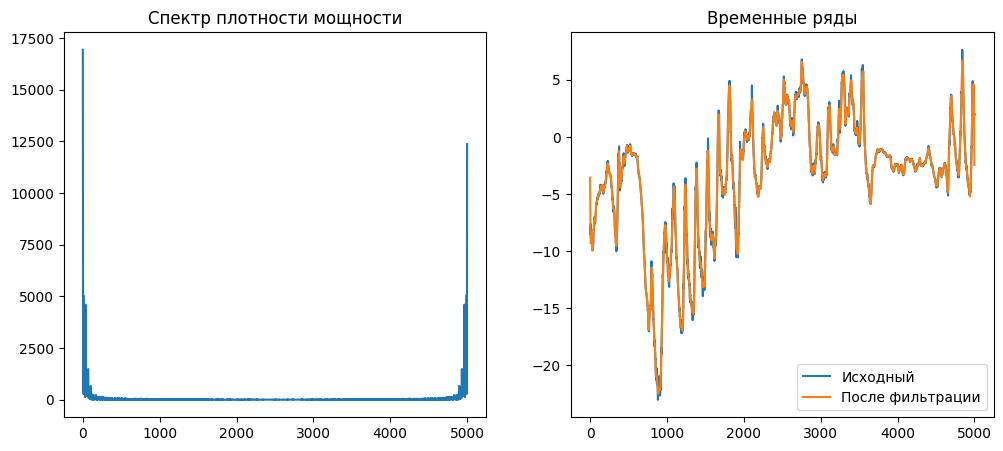

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq

# Читаем данные напрямую по ссылке
df = pd.read_csv(url_climate)
series = df['T (degC)'].values[:5000]  # для примера возьмём первые 5000 точек

# Применяем БПФ (FFT)
yf = fft(series)
xf = fftfreq(len(series), 1)

# Фильтруем высокие частоты
cutoff = int(len(yf) * 0.05)
yf_filtered = np.copy(yf)
yf_filtered[cutoff:-cutoff] = 0
series_filtered = np.real(ifft(yf_filtered))

# Графики
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(np.abs(yf))
plt.title('Спектр плотности мощности')
plt.subplot(1,2,2)
plt.plot(series, label='Исходный')
plt.plot(series_filtered, label='После фильтрации')
plt.legend()
plt.title('Временные ряды')
plt.show()

## Задание 2 — PCA для данных о диабете

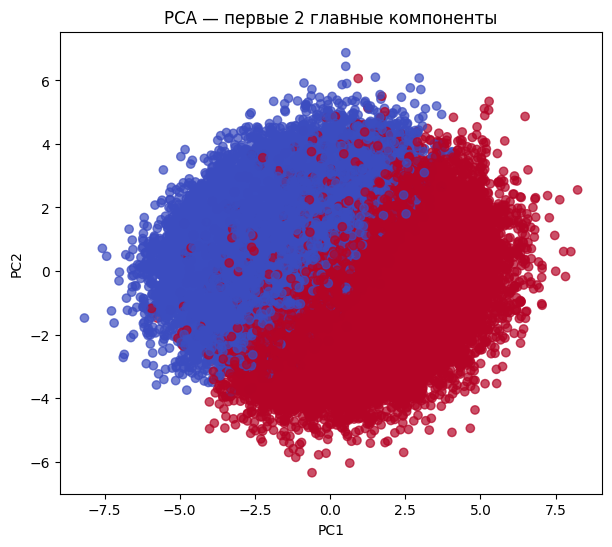

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv(url_diabetes)

# Кодируем категориальные данные
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Разделяем признаки и метку
X = df.drop(columns=['diagnosed_diabetes'])
y = df['diagnosed_diabetes']

# Масштабирование и PCA
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
components = pca.fit_transform(X_scaled)

# График PCA
plt.figure(figsize=(7,6))
plt.scatter(components[:,0], components[:,1], c=y, cmap='coolwarm', alpha=0.7)
plt.title('PCA — первые 2 главные компоненты')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Задание 3 — Сжатие изображения (FFT и SVD)

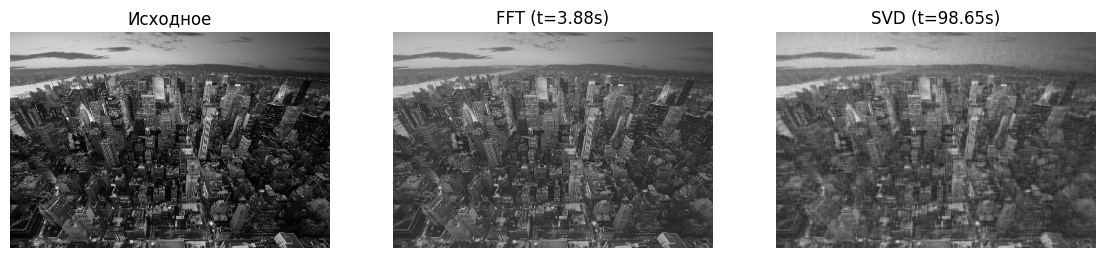

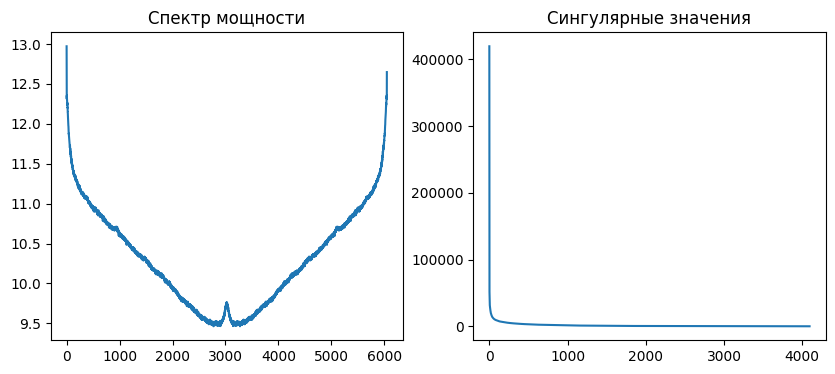

In [4]:
import time
from numpy.linalg import svd
from PIL import Image
import urllib.request

# Загружаем изображение напрямую по ссылке через Pillow
with urllib.request.urlopen(url_image) as f:
    image = np.array(Image.open(f))

# Преобразуем в градации серого
if image.ndim == 3:
    img_gray = np.mean(image, axis=2)
else:
    img_gray = image

# === FFT Compression ===
start = time.time()
f_transform = fft(fft(img_gray, axis=0), axis=1)
keep = int(0.1 * f_transform.shape[0])
f_filtered = np.copy(f_transform)
f_filtered[keep:-keep, :] = 0
compressed_fft = np.real(ifft(ifft(f_filtered, axis=0), axis=1))
fft_time = time.time() - start

# === SVD Compression ===
start = time.time()
U, S, Vt = svd(img_gray, full_matrices=False)
k = 50
compressed_svd = np.dot(U[:, :k], np.dot(np.diag(S[:k]), Vt[:k, :]))
svd_time = time.time() - start

# Графики результатов
plt.figure(figsize=(14, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.title('Исходное')
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(compressed_fft, cmap='gray')
plt.title(f'FFT (t={fft_time:.2f}s)')
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(compressed_svd, cmap='gray')
plt.title(f'SVD (t={svd_time:.2f}s)')
plt.axis('off')
plt.show()

# Спектр и сингулярные значения
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(np.log1p(np.abs(f_transform)).mean(axis=0))
plt.title('Спектр мощности')
plt.subplot(1, 2, 2)
plt.plot(S)
plt.title('Сингулярные значения')
plt.show()